In [ ]:
import os
os.environ["AZURE_OPENAI_API_KEY"] = ""
os.environ["AZURE_OPENAI_ENDPOINT"] = ""

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import news_signals
import datetime
import requests
import json
import re
import matplotlib.pyplot as plt
from openai import AzureOpenAI
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [43]:
ticker = "TSLA"            # Change ticker if needed
start_date = "2023-01-01"    # Start date for historical data
end_date = "2023-12-31"      # End date for historical data
window_size = 3            # 3-day rolling window

# Download daily stock data
data = yf.download(ticker, start=start_date, end=end_date)
data.index = pd.to_datetime(data.index)

def classify_window(window):
    """
        +1 if cumulative return > 5% and > volatility  (upward trend)
        -1 if cumulative return < -5% and < -volatility (downward trend)
         0 otherwise (neutral)
    """
    first_open = float(window['Open'].iloc[0])
    last_close = float(window['Close'].iloc[-1])
    cumulative_return = (last_close - first_open) / first_open
    daily_returns = (window['Close'] - window['Open']) / window['Open']
    volatility = float(daily_returns.std())
    
    if cumulative_return > 0.03 and cumulative_return > volatility:
        return 1
    elif cumulative_return < -0.03 and cumulative_return < -volatility:
        return -1
    else:
        return 0


# Apply a rolling window to classify the trend for each period
trend_results = []
dates = []
for i in range(window_size - 1, len(data)):
    window = data.iloc[i - window_size + 1 : i + 1]
    trend = classify_window(window)
    trend_results.append(trend)
    dates.append(data.index[i])

# Create a DataFrame with the trend classifications (using the last day of each window as the index)
rolling_trend_df = pd.DataFrame({'Trend': trend_results}, index=dates)
print(rolling_trend_df)

[*********************100%***********************]  1 of 1 completed
/var/folders/bl/qygrpx515yn2jk1zq7j95d_80000gp/T/ipykernel_2788/479097411.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  first_open = float(window['Open'].iloc[0])
/var/folders/bl/qygrpx515yn2jk1zq7j95d_80000gp/T/ipykernel_2788/479097411.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_close = float(window['Close'].iloc[-1])
/var/folders/bl/qygrpx515yn2jk1zq7j95d_80000gp/T/ipykernel_2788/479097411.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volatility = float(daily_returns.std())


            Trend
2023-01-05     -1
2023-01-06      0
2023-01-09      1
2023-01-10      1
2023-01-11      1
...           ...
2023-12-22      0
2023-12-26      0
2023-12-27      0
2023-12-28      0
2023-12-29     -1

[248 rows x 1 columns]


Class Distribution (Percentage):
Trend
 0    45.967742
 1    31.854839
-1    22.177419
Name: proportion, dtype: float64


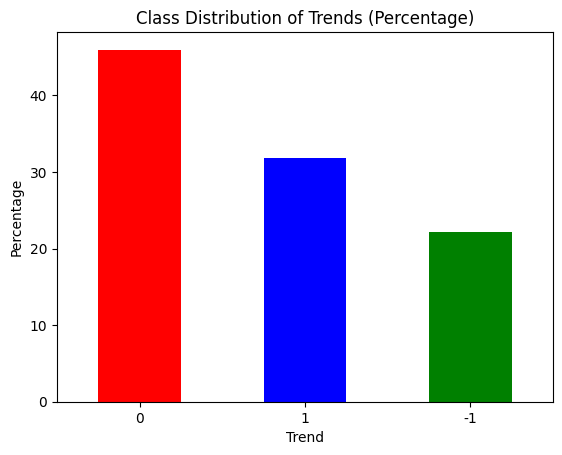

In [44]:

class_distribution = rolling_trend_df['Trend'].value_counts(normalize=True) * 100
print("Class Distribution (Percentage):")
print(class_distribution)

# Plot the class distribution as percentages
class_distribution.plot(kind='bar', color=['red', 'blue', 'green'])
plt.title('Class Distribution of Trends (Percentage)')
plt.xlabel('Trend')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

In [30]:
import pandas as pd
import requests
import json
import re

# 1) Load your CSV file
df = pd.read_csv("entity_news_paged.csv")

# 2) Define a function to call the Azure OpenAI API (GPT-4) with your filtering prompt
def process_article_with_azure(title, body):
    prompt = f"""
I am providing you with a news article. Only extract content about or related to Tesla, Elon Musk, TSLA stocks or things that could affect them.
Give me the relevant content with context without any changes to the relevant text. Do not add headings like "Sure, here are the paragraphs." 
Simply output the paragraphs, each separated by a blank line (or keep their original spacing). If the news article does not contain any relevant information, then only output "Nope". 
Do not specify paragraph numbers or anything, simply output their content without any identifiers. 
**Important**: 
- Do not paraphrase, summarize, or change the text in any way. 
- Output exactly the extracted paragraphs, one after another, with no additional commentary

below is the article

Title: {title}

Body: {body}
    """.strip()
    
     # Get API key and endpoint from environment variables
    api_key = os.environ["AZURE_OPENAI_API_KEY"]
    endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]
    # Ensure the endpoint URL is for chat completions, e.g.
    # "https://<your-resource-name>.openai.azure.com/openai/deployments/<deployment-name>/chat/completions?api-version=2024-08-01-preview"
    
    headers = {
        "Content-Type": "application/json",
        "api-key": api_key
    }
    
    # For the Chat Completions endpoint, use the "messages" format
    payload = {
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "max_tokens": 500,
        "temperature": 0,
        "top_p": 1,
        "n": 1
    }
    
    try:
        response = requests.post(endpoint, headers=headers, json=payload, timeout=60)
        response.raise_for_status()
        data = response.json()
        # Check for the output in data["choices"][0]["message"]
        message = data["choices"][0]["message"]
        # Try "content" key first, then "text"
        result = message.get("content")
        if result is None:
            result = message.get("text", "")
        return result.strip()
    except requests.RequestException as e:
        return f"Error calling Azure OpenAI API: {e}"
    except (KeyError, IndexError) as e:
        return f"Unexpected response structure: {e}"

# 3) Create a new column to store Azure's processed text
processed_texts = []

# 4) Iterate over rows, process each article, and collect responses
num_articles = len(df)
for idx, row in df.iterrows():
    title = str(row["title"])
    body = str(row["body"])
    processed = process_article_with_azure(title, body)
    processed_texts.append(processed)
    print(f"Processed {idx+1} / {num_articles} articles so far.")
    print("Azure Response:\n", processed, "\n")
    
# 5) Add the processed text as a new column in the DataFrame
df["Processed_Article"] = processed_texts

# 6) Save the updated DataFrame to a new CSV file (retaining all original columns)
output_filename = "entity_news_processed_azure.csv"
df.to_csv(output_filename, index=False)
print(f"Saved processed articles to {output_filename}")

Processed 1 / 2277 articles so far.
Azure Response:
 Nope 



KeyboardInterrupt: 

In [45]:
import pandas as pd

# Load the processed CSV file
df = pd.read_csv("entity_news_processed_azure.csv")

# Drop the "title" and "body" columns
df_reduced = df.drop(columns=["title", "body"])

# Save the reduced DataFrame to a new CSV file
output_filename = "entity_news_processed_azure_reduced.csv"
df_reduced.to_csv(output_filename, index=False)
print(f"Saved reduced CSV with only the processed article and other columns to {output_filename}")


Saved reduced CSV with only the processed article and other columns to entity_news_processed_azure_reduced.csv


In [46]:
import pandas as pd

# Load the processed news CSV (which should have columns "published_at" and "Processed_Article")
news_df = pd.read_csv("entity_news_processed_azure_reduced.csv")
news_df["published_at"] = pd.to_datetime(news_df["published_at"]).dt.tz_convert(None)

# Assume you already have the financial data DataFrame (rolling_trend_df) from your previous code
rolling_trend_df_reset = rolling_trend_df.reset_index().rename(columns={'index': 'Date'})
rolling_trend_df_reset["Date"] = pd.to_datetime(rolling_trend_df_reset["Date"])
rolling_trend_df_reset = rolling_trend_df_reset.sort_values("Date")
print("Financial data with trends:")
print(rolling_trend_df_reset)

# Define the starting boundary for the news window (finance start date)
finance_start_date = pd.to_datetime("2023-01-01")
attached_news = []  # List to store combined news for each financial window

prev_date = finance_start_date

# Iterate over each financial date and attach processed news articles published in the interval [prev_date, current_date)
for current_date in rolling_trend_df_reset["Date"]:
    # Select news articles with published_at >= prev_date and < current_date
    mask = (news_df["published_at"] >= prev_date) & (news_df["published_at"] < current_date)
    window_news = news_df[mask]
    
    # Combine the Processed_Article texts from the filtered news, separated by a blank line
    combined_text = "\n\n".join(str(x) for x in window_news["Processed_Article"].fillna("").tolist())
    attached_news.append(combined_text)
    
    # Update prev_date to the current financial date for the next window
    prev_date = current_date

# Add the combined processed news as a new column in the financial DataFrame
rolling_trend_df_reset["Processed_News"] = attached_news

# Optionally, if you want to remove the original title and body columns (if present), you can drop them:
# rolling_trend_df_reset = rolling_trend_df_reset.drop(columns=["title", "body"], errors="ignore")

# Save the updated DataFrame to a new CSV file
output_filename = "trend_processed_news.csv"
rolling_trend_df_reset.to_csv(output_filename, index=False)
print(f"Saved updated financial data with attached processed news to {output_filename}")


Financial data with trends:
          Date  Trend
0   2023-01-05     -1
1   2023-01-06      0
2   2023-01-09      1
3   2023-01-10      1
4   2023-01-11      1
..         ...    ...
243 2023-12-22      0
244 2023-12-26      0
245 2023-12-27      0
246 2023-12-28      0
247 2023-12-29     -1

[248 rows x 2 columns]
Saved updated financial data with attached processed news to trend_processed_news.csv


In [47]:
import pandas as pd

# Load the CSV file with attached processed news
df = pd.read_csv("trend_processed_news.csv")

# Remove all occurrences of "Nope" from the "Processed_News" column
df["Processed_News"] = df["Processed_News"].str.replace("Nope", "", regex=False)
df["Processed_News"] = df["Processed_News"].str.replace("_blank", "", regex=False)

# Save the cleaned DataFrame to a new CSV file
output_filename = "trend_processed_news_cleaned.csv"
df.to_csv(output_filename, index=False)
print(f"Saved cleaned CSV to {output_filename}")

Saved cleaned CSV to trend_processed_news_cleaned.csv


In [48]:
df = pd.read_csv("trend_processed_news_cleaned.csv")

# Fill missing values in the 'News' column with an empty string
news_text = df["Processed_News"].fillna("").astype(str)


vectorizer = TfidfVectorizer(
    stop_words="english",
    ngram_range=(2,3),
    max_features=500000,
    min_df=5,
    max_df=0.2
)


tfidf_matrix = vectorizer.fit_transform(news_text)

# Display the shape of the resulting TF-IDF matrix
print("TF-IDF matrix shape:", tfidf_matrix.shape)

feature_names = vectorizer.get_feature_names_out()
print("First 20 feature names:", feature_names[:50])

TF-IDF matrix shape: (248, 2141)
First 20 feature names: ['000 cars' '000 cheaper' '000 deliveries' '000 evs' '000 higher'
 '000 model' '000 price' '000 tesla' '000 units' '000 vehicle'
 '000 vehicles' '10 000' '10 2023' '10 times' '10 years' '100 000'
 '100 million' '11 month' '12 000' '12 6bn' '12 month' '12 months'
 '15 000' '150 lightning' '18 months' '19 year' '20 000' '20 million'
 '20 year' '200 000' '200 billion' '2018 tesla' '2018 tweet' '2018 tweets'
 '2019 tesla' '2021 tesla' '2022 according' '2022 company' '2022 elon'
 '2022 musk' '2022 tesla' '2023 earnings' '2023 elon' '2023 elon musk'
 '2023 model' '2023 model vehicles' '2023 musk' '2023 tesla' '24 billion'
 '24 hours']


In [49]:
y = df["Trend"]

# Split data into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42)

# Initialize and train a Logistic Regression classifier
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Display the test set accuracy and classification report
print("Test set accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display top features for each trend class
feature_names = vectorizer.get_feature_names_out()
for class_label in np.unique(y_train):
    class_index = list(clf.classes_).index(class_label)
    coef = clf.coef_[class_index]
    top_indices = np.argsort(coef)[-10:][::-1]
    print(f"\nTop features for trend class {class_label}:")
    for i in top_indices:
        print(f"{feature_names[i]}: {coef[i]:.4f}")

Test set accuracy: 60.00%

Classification Report:
              precision    recall  f1-score   support

          -1       0.50      0.17      0.25         6
           0       0.74      0.76      0.75        33
           1       0.29      0.36      0.32        11

    accuracy                           0.60        50
   macro avg       0.51      0.43      0.44        50
weighted avg       0.61      0.60      0.59        50


Top features for trend class -1:
steering wheels: 0.6519
tesla cuts: 0.5941
tesla semi: 0.5179
non tesla: 0.4818
gross margin: 0.4786
mark zuckerberg: 0.4717
cuts prices: 0.4640
tesla cuts prices: 0.4633
musk mr: 0.4620
40 000: 0.4281

Top features for trend class 0:
open letter: 0.4313
told reporters: 0.4251
tesla open: 0.4004
market share: 0.3756
collective bargaining: 0.3588
company xai: 0.3526
bargaining agreement: 0.3396
collective bargaining agreement: 0.3396
october year: 0.3198
cash flow: 0.3030

Top features for trend class 1:
tesla private: 0.5769
fund

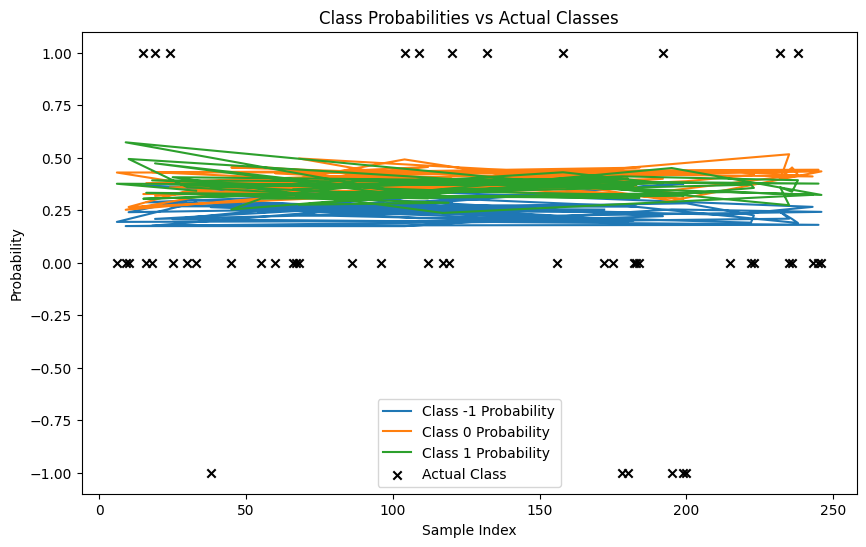

In [50]:
import matplotlib.pyplot as plt

# Get the probabilities for each class
y_proba = clf.predict_proba(X_test)

# Plot the probabilities
plt.figure(figsize=(10, 6))
for i, class_label in enumerate(clf.classes_):
    plt.plot(y_test.index, y_proba[:, i], label=f'Class {class_label} Probability')

# Plot the actual classes
plt.scatter(y_test.index, y_test, color='black', marker='x', label='Actual Class')

plt.xlabel('Sample Index')
plt.ylabel('Probability')
plt.title('Class Probabilities vs Actual Classes')
plt.legend()
plt.show()

In [51]:
# Predict on the training set
y_train_pred = clf.predict(X_train)

# Display the training set accuracy and classification report
print("Training set accuracy: {:.2f}%".format(accuracy_score(y_train, y_train_pred) * 100))
print("\nClassification Report (Training Set):")
print(classification_report(y_train, y_train_pred))

Training set accuracy: 91.92%

Classification Report (Training Set):
              precision    recall  f1-score   support

          -1       1.00      0.82      0.90        49
           0       0.84      1.00      0.91        81
           1       1.00      0.90      0.95        68

    accuracy                           0.92       198
   macro avg       0.95      0.90      0.92       198
weighted avg       0.93      0.92      0.92       198



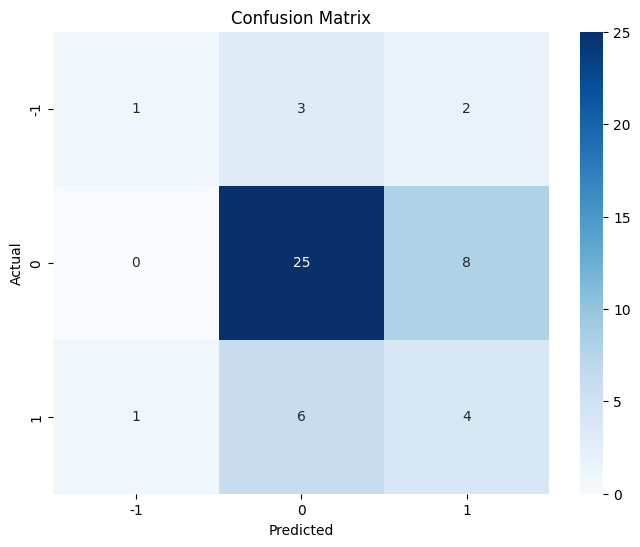

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()